In [3]:
## For debbugging
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# import os
import sys
from pathlib import Path
module_path = Path('.').resolve().parents[1]
if module_path not in sys.path:
    sys.path.append(str(module_path))


In [5]:
## for debugging:
# %aimport mlp.keyword
# %aimport mlp.tools
%aimport mlp.kex
%aimport app.test_app
# %aimport mlp.tree
%autoreload 1
from mlp.kex import *


In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm
%matplotlib inline

In [7]:
%gui qt
import PyQt5.QtWidgets as qw
from app.test_app import MyWindow
from PyQt5 import QtCore



In [8]:
import dask.dataframe as dd
import dask
import string
from fuzzywuzzy import process as zz

# HVAC Maintenance Case Study

## Import Data

In [9]:
data_dir = module_path/'data'/'hvac_data'
df = dd.read_csv(data_dir/'hvac_data.csv',sample = 200000000, low_memory=False)
# really important things we know, a priori
special_replace={'action taken:': '',
                 ' -': '; ',
                 '- ': '; ',
                 'too hot': 'too_hot',
                 'to hot': 'too_hot',
                 'too cold': 'too_cold',
                 'to cold': 'too_cold'}

gs_nlp_select = NLPSelect(columns = ['DESCRIPTION', 'LONG_DESCRIPTION'], special_replace=special_replace)
raw_text = gs_nlp_select.transform(df)#.compute()

### Build Vocab

In [10]:

tex = TokenExtractor()
toks = tex.fit_transform(raw_text)
print(tex.vocab_)

['action' 'taken' 'room' ..., 'eye' 'pictures' 'italic']


In [11]:
vocab_fname = data_dir/'vocab.csv'
# vocab_fname = data_dir/'mine_vocab_app.csv'

# vocab = tex.annotation_assistant(filename = vocab_fname)
vocab = tex.annotation_assistant(init = vocab_fname)

intialized successfully!


### Use these if you want to graphically edit the vocab

In [24]:
if __name__ == '__main__':

    app = QtCore.QCoreApplication.instance()
    if app is None:
        app = app = qw.QApplication(sys.argv)

    window = MyWindow(vocab_filename=vocab_fname)
    window.show()

    app.exec_()

In [25]:
vocab = tex.annotation_assistant(init=vocab_fname)

intialized successfully!


### Extract Keywords

In [12]:
idx_col = pd.DatetimeIndex(df.REPORTDATE.compute())
tag_df = tags_to_df(tag_extractor(tex, raw_text, toks, vocab))

HBox(children=(IntProgress(value=0, description='Category Loop', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='I token loop', max=44), HTML(value='')))

HBox(children=(IntProgress(value=0, description='NA token loop', max=4662), HTML(value='')))

HBox(children=(IntProgress(value=0, description='P token loop', max=8), HTML(value='')))

HBox(children=(IntProgress(value=0, description='S token loop', max=16), HTML(value='')))

HBox(children=(IntProgress(value=0, description='U token loop', max=14), HTML(value='')))

HBox(children=(IntProgress(value=0, description='X token loop', max=3), HTML(value='')))

In [13]:

# vocab = pd.read_csv(data_dir/'app_vocab_mike.csv', index_col=0)
# how many instances of each keyword class are there?
print('named entities: ')
print('I\tItem\nP\tProblem\nS\tSolution\nR\tRedundant')
print('U\tUnknown\nX\tStop Word')
print('total tokens: ', vocab.NE.notna().sum())
print('total tags: ', vocab.groupby("NE").nunique().alias.sum())
vocab.groupby("NE").nunique()

named entities: 
I	Item
P	Problem
S	Solution
R	Redundant
U	Unknown
X	Stop Word
total tokens:  338
total tags:  85


NE  alias  notes  score
NE                         
I    1     44      4    206
P    1      8      1     25
S    1     16      2     74
U    1     14      7     27
X    1      3      2      6

Tag completeness: 0.66 +/- 0.18
Tag empty: 32, or 0.19%


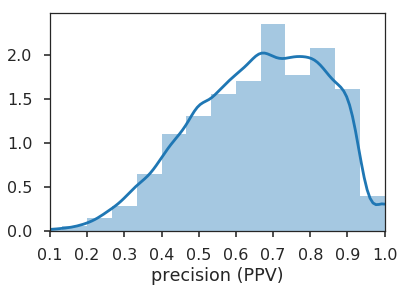

In [14]:
# tag-completeness of work-orders?
wo_tot = len(df)
tag_comp = 1-(tag_df['NA'].sum(axis=1)/tag_df.sum(axis=1))
              
print(f'Tag completeness: {tag_comp.mean():.2f} +/- {tag_comp.std():.2f}')
with sns.axes_style('ticks') as style,\
sns.plotting_context('poster') as context:
    sns.distplot(tag_comp.dropna(), bins=15, kde_kws={'cut':0})
    plt.xlim(0.1, 1.0)
    plt.xlabel('precision (PPV)')
    # sns.kdeplot()

# tag-empty? 
tag_empt = ((tag_df['I'].sum(axis=1)==0)&(tag_df['P'].sum(axis=1)==0)&(tag_df['S'].sum(axis=1)==0)).sum()
print(f'Tag empty: {tag_empt}, or {tag_empt/wo_tot:.2%}')

## Measuring Machine Performance

Text(0.5,0.98,'Tag Occurence')

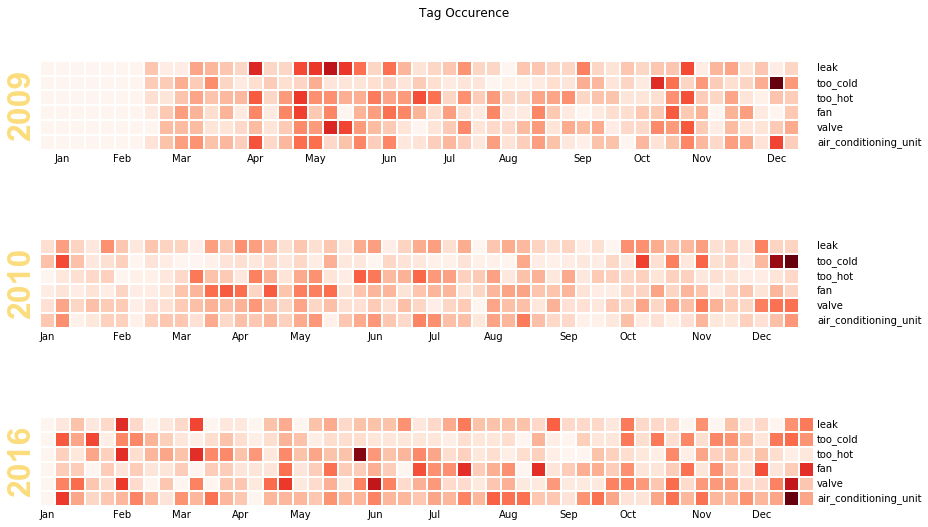

In [15]:
from mlp import plot

samp = ['air_conditioning_unit','fan', 'valve', 'leak', 'too_hot', 'too_cold']
cond = (tag_df.P.alarm==1)
sample_tag = tag_df.loc[:,(slice(None), samp)]
sample_tag.columns = sample_tag.columns.droplevel(0)

sample_tag = sample_tag.set_index(idx_col[:])

sample_tag = sample_tag[ sample_tag.index.year.isin([2009, 2010, 2016])]
plot.calendarplot(sample_tag,
                  how='sum', fig_kws={'figsize':(13,8)});
plt.suptitle('Tag Occurence')

In [16]:
# import holoviews as hv
# # import geoviews as gv
# hv.extension('bokeh')

### Monthly "too-hot" and "too-cold" requests, over time

Index(['too_hot', 'too_cold'], dtype='object')


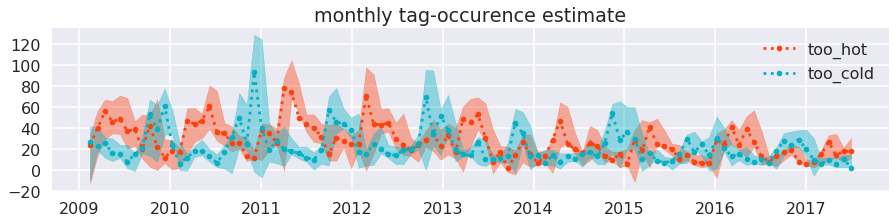

In [17]:
# .rolling(1000).sum()
samp = ['too_cold', 'too_hot']
sample_tag = tag_df.loc[:,(slice(None), samp)]
sample_tag.columns = sample_tag.columns.droplevel(0)

sample_tag = sample_tag.set_index(idx_col).sort_index()

with sns.axes_style('darkgrid') as style,\
sns.plotting_context('poster') as context:
    plt.figure(figsize=(15,3))
    sample_tag.resample('30D').sum()
    plt.plot(sample_tag.too_hot.resample('30D').sum(), 
             marker='.', ls=':', color='xkcd:orangered', label='too_hot')
    plt.plot(sample_tag.too_cold.resample('30D').sum(), 
             marker='.', ls=':', color='xkcd:turquoise blue', label='too_cold')
    roll = sample_tag.rolling('30D').sum()
    mean = roll.resample('30D').mean()
    err = roll.resample('30D').std()
    plt.fill_between(mean.index, mean.too_hot-3*err.too_hot, mean.too_hot+3*err.too_hot,
                    alpha=.4, color='xkcd:orangered')
    plt.fill_between(mean.index, mean.too_cold-3*err.too_cold, mean.too_cold+3*err.too_cold,
                    alpha=.4, color='xkcd:turquoise blue')
    sns.despine()
    plt.legend()
    plt.title('monthly tag-occurence estimate')
# df.resample()
print(sample_tag.columns)

### Interactive!

[click for html](./nist_hvac_map.html)

In [20]:
%%output size=250 
# %%opts Spread [width=300, height=80] (line_color=None, alpha=.4 color=hv.Cycle(['#fe420f', '#06b1c4']))
# %%opts Curve (color=hv.Cycle(['#fe420f', '#06b1c4']) line_dash='dotted')
# %%opts Scatter ( size=5, color=hv.Cycle(['#fe420f', '#06b1c4']))

temp_curve_spec = {
    'Spread':{'plot':{'width':300, 'height':80}, 
              'style':dict(line_color=None, alpha=.4, color=hv.Cycle(['#fe420f', '#06b1c4']))},
    'Curve':{'style':dict(color=hv.Cycle(['#fe420f', '#06b1c4']), line_dash='dotted')},
    'Scatter':{'style':dict( size=5, color=hv.Cycle(['#fe420f', '#06b1c4']))}
}

samp = ['too_cold', 'too_hot']
sample_tag = tag_df.loc[:,(slice(None), samp)]
sample_tag.columns = sample_tag.columns.droplevel(0)

sample_tag = sample_tag.set_index(idx_col).sort_index()
meas = sample_tag.resample('30D').sum()
roll = sample_tag.rolling('30D').sum()
mean = roll.resample('30D').mean()
err = roll.resample('30D').std()
    
temp_curves = hv.Overlay([hv.Spread((mean.index, mean.too_hot, 2*err.too_hot)),
                          hv.Spread((mean.index, mean.too_cold, 2*err.too_cold)),
                          hv.Curve((meas.index, meas.too_hot)),
                          hv.Curve((meas.index, meas.too_cold)),
                          hv.Scatter((meas.index, meas.too_hot), label='too_hot'),
                          hv.Scatter((meas.index, meas.too_cold), label='too_cold')])
temp_curves.opts(temp_curve_spec)#*hv.VLine(times[5])

:Overlay
   .Spread.I         :Spread   [x]   (y,yerror)
   .Spread.II        :Spread   [x]   (y,yerror)
   .Curve.I          :Curve   [x]   (y)
   .Curve.II         :Curve   [x]   (y)
   .Scatter.Too_hot  :Scatter   [x]   (y)
   .Scatter.Too_cold :Scatter   [x]   (y)

In [84]:
import geopandas as gpd 
nist_df = gpd.read_file(str(data_dir/'nist_map.geojson')).set_index('bldg', drop=False)
nist_df.index = nist_df.index.astype(str)
samp = ['too_cold', 'too_hot']
sample_tag = tag_df.loc[:,(slice(None), samp)]
sample_tag.columns = sample_tag.columns.droplevel(0)

bldg_col = df.LOCATION.compute().str.split('-').str[0].astype('category')
sample_tag = pd.concat([sample_tag, bldg_col], axis=1)
sample_tag = sample_tag.set_index(idx_col).sort_index()
sample_tag.rename({'LOCATION':'bldg'}, axis='columns', inplace=True)

times = sample_tag.resample('30D').sum().index
# pd.concat([sample_tag.loc[times[0]:times[1]].groupby('bldg').sum(), nist_df], axis=1).dropna()

def get_bldg_temp(n):
    data = gpd.GeoDataFrame(pd.concat([sample_tag.loc[times[n]:times[n+1]].groupby('bldg').sum(), 
                      nist_df], 
                     axis=1).dropna())
    data['Temperature Index'] = np.tanh((data['too_cold'].sum()+data['too_hot'].sum())/20)*\
    (data['too_cold'] - data['too_hot'])
    return data
# np.tanh((data['too_cold'].sum()+data['too_hot'].sum())/20)*\
get_bldg_temp(1).head()


/home/tbsexton/anaconda3/lib/python3.6/site-packages/dask/local.py:290: DtypeWarning: Columns (29,30,40,106,172,196,217,227) have mixed types. Specify dtype option on import or set low_memory=False.
  result = _execute_task(task, data)


too_hot  too_cold   bldg  \
bldg                             
101         2         3  101.0   
202         0         1  202.0   
203         0         0  203.0   
205         0         0  205.0   
215         1         0  215.0   

                                               geometry  Temperature Index  
bldg                                                                        
101   POLYGON ((-77.2163987159729 39.13512015465694,...           0.995524  
202   POLYGON ((-77.22025036811827 39.13047428646352...           0.995524  
203   POLYGON ((-77.22077608108521 39.13020796677279...           0.000000  
205   POLYGON ((-77.21850156784058 39.1223198699503,...           0.000000  
215   POLYGON ((-77.21671521663666 39.1316623096919,...          -0.995524

In [92]:
%%output size=200
# gv.Polygons(get_bldg_temp(0))
# gv.Polygons(nist_df)
from bokeh.palettes import Viridis10, Category10_6, RdBu10
from bokeh.models.mappers import LinearColorMapper
RdBu10.reverse()

padding = dict(x=(-77.223, -77.214), y=(39.13, 39.14))
extents = (-77.223, 39.129, -77.214, 39.1385)

bldg_dict, vlines = {}, {}
for n, time in enumerate(times[:-1]):
    mapped = gv.Polygons(get_bldg_temp(n), 
                         vdims=['Temperature Index', 'bldg', 'too_hot', 'too_cold'],
                         extents = extents)
    mapped = mapped.redim.range(**padding)
    vlines[time] = hv.VLine(time).opts(style={'color':'black'})
    bldg_dict[time] = mapped
    
text = hv.Overlay([gv.Text(i.centroid.x-.0002, 
                           i.centroid.y-.00015, 
                           str(name)) for name,i in get_bldg_temp(0).geometry.iteritems()])
# hv.HeatMap()
# RdBu.reverse()

# color_mapper = LinearColorMapper(palette=RdBu[10].reverse(), low=-5, high=5)


bldg_dict[times[0]]*text
# text.redim.range(**padding)

:Overlay
   .Polygons.I  :Polygons   [Longitude,Latitude]   (Temperature Index,bldg,too_hot,too_cold)
   .Text.I      :Text   [x,y]
   .Text.II     :Text   [x,y]
   .Text.III    :Text   [x,y]
   .Text.IV     :Text   [x,y]
   .Text.V      :Text   [x,y]
   .Text.VI     :Text   [x,y]
   .Text.VII    :Text   [x,y]
   .Text.VIII   :Text   [x,y]
   .Text.IX     :Text   [x,y]
   .Text.X      :Text   [x,y]
   .Text.XI     :Text   [x,y]
   .Text.XII    :Text   [x,y]
   .Text.XIII   :Text   [x,y]
   .Text.XIV    :Text   [x,y]
   .Text.XV     :Text   [x,y]
   .Text.XVI    :Text   [x,y]
   .Text.XVII   :Text   [x,y]
   .Text.XVIII  :Text   [x,y]
   .Text.XIX    :Text   [x,y]
   .Text.XX     :Text   [x,y]
   .Text.XXI    :Text   [x,y]
   .Text.XXII   :Text   [x,y]
   .Text.XXIII  :Text   [x,y]
   .Text.XXIV   :Text   [x,y]
   .Text.XXV    :Text   [x,y]
   .Text.XXVI   :Text   [x,y]
   .Text.XXVII  :Text   [x,y]
   .Text.XXVIII :Text   [x,y]
   .Text.XXIX   :Text   [x,y]
   .Text.XXX    :Text   [x,y]

In [93]:
%%output size=200 filename='nist_hvac_map'
%%opts Polygons [height=350 width=300, tools=['hover'] colorbar=False ] (cmap='RdBu')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# , bounds = (-77.222, 39.13, -77.215, 39.14)
# bldg_dict[times[11]].cols(1)
# hv.HoloMap(bldg_dict)

(hv.HoloMap(bldg_dict, 'Time')*text + hv.HoloMap(vlines, 'Time')*temp_curves.opts(temp_curve_spec)).cols(1)
# hv.Bounds()

:Layout
   .HoloMap.I  :HoloMap   [Time]
      :Overlay
         .Polygons.I  :Polygons   [Longitude,Latitude]   (Temperature Index,bldg,too_hot,too_cold)
         .Text.I      :Text   [x,y]
         .Text.II     :Text   [x,y]
         .Text.III    :Text   [x,y]
         .Text.IV     :Text   [x,y]
         .Text.V      :Text   [x,y]
         .Text.VI     :Text   [x,y]
         .Text.VII    :Text   [x,y]
         .Text.VIII   :Text   [x,y]
         .Text.IX     :Text   [x,y]
         .Text.X      :Text   [x,y]
         .Text.XI     :Text   [x,y]
         .Text.XII    :Text   [x,y]
         .Text.XIII   :Text   [x,y]
         .Text.XIV    :Text   [x,y]
         .Text.XV     :Text   [x,y]
         .Text.XVI    :Text   [x,y]
         .Text.XVII   :Text   [x,y]
         .Text.XVIII  :Text   [x,y]
         .Text.XIX    :Text   [x,y]
         .Text.XX     :Text   [x,y]
         .Text.XXI    :Text   [x,y]
         .Text.XXII   :Text   [x,y]
         .Text.XXIII  :Text   [x,y]
         .Text.XXIV   :Text   [x,y]
         .Text.XXV    :Text   [x,y]
         .Text.XXVI   :Text   [x,y]
         .Text.XXVII  :Text   [x,y]
         .Text.XXVIII :Text   [x,y]
         .Text.XXIX   :Text   [x,y]
         .Text.XXX    :Text   [x,y]
   .HoloMap.II :HoloMap   [Time]
      :Overlay
         .VLine.I          :VLine   [x,y]
         .Spread.I         :Spread   [x]   (y,yerror)
         .Spread.II        :Spread   [x]   (y,yerror)
         .Curve.I          :Curve   [x]   (y)
         .Curve.II         :Curve   [x]   (y)
         .Scatter.Too_hot  :Scatter   [x]   (y)
         .Scatter.Too_cold :Scatter   [x]   (y)

In [98]:
from IPython.display import HTML

HTML(filename="./nist_hvac_map.html")

In [27]:
df.LOCATION.compute().str.split('-').str[0].astype('category')
# df.ASSETNUM.compute().str.split(' ').str[1].astype('category')

/home/tbsexton/anaconda3/lib/python3.6/site-packages/dask/local.py:290: DtypeWarning: Columns (29,30,40,106,172,196,217,227) have mixed types. Specify dtype option on import or set low_memory=False.
  result = _execute_task(task, data)


0        GAITHER
1            215
2            301
3            304
4            220
5            221
6            235
7            230
8            101
9            230
10           301
11           223
12           223
13           101
14           245
15           226
16           226
17           NaN
18           226
19           301
20           301
21           101
22           235
23           222
24           215
25           101
26           236
27           NaN
28           101
29           101
          ...   
16956        219
16957        226
16958        101
16959        231
16960        304
16961        101
16962        101
16963        101
16964        101
16965        245
16966        245
16967        233
16968        227
16969        238
16970        220
16971        235
16972        304
16973        304
16974        217
16975        223
16976        225
16977        218
16978        420
16979        219
16980        227
16981        223
16982        223
16983        2

### 2-grams

In [33]:
thes_dict = vocab[vocab.alias.notna()].alias.to_dict()
substr = sorted(thes_dict, key=len, reverse=True)
# matcher = lambda s: r'\b'+re.escape(s)+r'\b'
# matcher = lambda s: re.escape(s)
rx = re.compile(r'\b(' + '|'.join(map(re.escape, substr))+ r')\b')
clean_text = raw_text.str.replace(rx, lambda match: thes_dict[match.group(0)])
clean_text.compute()[:4]
# TfidfVectorizer()
# '(?u)\\b\\w\\w+\\b'

0     replace lubricant tank fill hose 
1         checked rotary head alignment
2       reweld shock sub to rotary head
3    centre tank not filling with water
dtype: object

In [34]:
from itertools import combinations, permutations, product
tex2 = TokenExtractor(ngram_range = (2,2))
#                       vocabulary=[' '.join(i) for i in combinations(vocab[vocab.alias.notna()].alias.unique(), 2)])
toks2 = tex2.fit_transform(clean_text)
print(tex2.vocab_)
voc2 = tex2.annotation_assistant(data_dir/'2g_mine_vocab_test.csv')

['lubricant service' 'oil leak' 'pm lubricant' ... 'station check'
 'check 24wk' 'fitter hydraulic']
New Vocab. file written to /home/tbsexton/Documents/Projects/DiagnosticKB/MaintenanceLanguageProcessing/data/mine_data/2g_mine_vocab_test.csv


SystemExit: 0

/home/tbsexton/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [35]:
NE_dict = vocab.NE.fillna('U').to_dict()
NE_dict.update(vocab.fillna('U').reset_index()[['NE', 'alias']].drop_duplicates().set_index('alias').NE.to_dict())
NE_sub = sorted(NE_dict, key=len, reverse=True)

# matcher = lambda s: r'\b'+re.escape(s)+r'\b'
# matcher = lambda s: re.escape(s)
NErx = re.compile(r'\b(' + '|'.join(map(re.escape, NE_sub))+ r')\b')
NE_text = voc2.index.str.replace(NErx, lambda match: NE_dict[match.group(0)])
voc2.loc[:,'NE'] = NE_text.tolist()



# g = vocab.groupby('alias')
# for one_grams in voc2.index.str.split().tolist():
#     for one_gram in one_grams:
#         try:
#             print(g.get_group(one_gram).NE[0])
#         except KeyError:
#             pass

TypeError: object of type 'float' has no len()

In [147]:
NE_map = {' '.join(i):'' for i in product('IPSUX', repeat=2)}

NE_map['I I'] = 'I'
NE_map['S I'] = 'S I'
NE_map['P I'] = 'P I'

NE_map['I S'] = 'S I'
NE_map['I P'] = 'P I'

NE_map['S S'] = 'X'
NE_map['P P'] = 'X'
NE_map['S P'] = 'X'
NE_map['P S'] = 'X'
# NE_map['']
voc2['NE'] = voc2.NE.apply(lambda x: NE_map[x])
# voc2_est.to_csv('test_estimated_2g.csv')
# voc2_est[(voc2_est!='') & (voc2_est!='X')]
voc2['score'] = tex2.scores_
# voc2.NE

# OLD

In [138]:
# tqdm.pandas(desc="KEx")
from sklearn.feature_extraction import stop_words
 
# print(stop_words.ENGLISH_STOP_WORDS)

thes_dict = vocab[vocab.alias.notna()].alias.to_dict()
substr = sorted(thes_dict, key=len, reverse=True)
rx = re.compile('|'.join(map(re.escape, substr)))

toks = raw_text.str.split()
toks = toks.apply(lambda d: d if isinstance(d, list) else [], 
                             meta=toks)

tags = raw_text.str.replace(rx, lambda match: thes_dict[match.group(0)]).str.split()
tags = tags.apply(lambda d: d if isinstance(d, list) else [], 
                             meta=tags)

grps = vocab.groupby('NE')

# have to pre-allocate column names...dask doesn't like loops :(
tagI = tags.apply(lambda x: list(set(grps.get_group('I')['alias'].astype(str).tolist()) & set(x)),
                  meta=('I', object)).str.join(', ')
tagP = tags.apply(lambda x: list(set(grps.get_group('P')['alias'].astype(str).tolist()) & set(x)),
                  meta=('P', object)).str.join(', ')
tagS = tags.apply(lambda x: list(set(grps.get_group('S')['alias'].astype(str).tolist()) & set(x)),
                  meta=('S', object)).str.join(', ')

tagU = toks.apply(lambda x: list(set(x) - set(vocab.index) - set(stop_words.ENGLISH_STOP_WORDS)),
                  meta=('U', object)).str.join(', ')

ndf = dd.concat([ tagI, tagP, tagS, tagU], axis=1)


/home/tbsexton/anaconda3/lib/python3.6/site-packages/dask/dataframe/multi.py:571: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indexes of each dataframes are 
aligned. This assumption is not generally safe.
  warn("Concatenating dataframes with unknown divisions.\n"


In [139]:
from dask.diagnostics import ProgressBar, Profiler, ResourceProfiler, CacheProfiler, visualize
from dask.distributed import Client
import dask

## multiproc, not thread, due to GIL with text. 
with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof, CacheProfiler() as cprof:
    with ProgressBar(), dask.set_options(get=dask.multiprocessing.get):
        tag_df=ndf.compute()

# visualize([prof, rprof, cprof])
tag_df.head()

[########################################] | 100% Completed |  3.5s


I       P                  S U
0                 chain, feeder  broken             repair  
1  machine, cable, pendant, pin   short            replace  
2                          part  broken      order, repair  
3                   accumulator          ok, charge, check  
4    attachment, saw, hydraulic    leak            replace

In [140]:
tag_df['og'] = raw_text
tag_df

I                    P  \
0                                      chain, feeder               broken   
1                       machine, cable, pendant, pin                short   
2                                               part               broken   
3                                        accumulator                        
4                         attachment, saw, hydraulic                 leak   
5                                       unit, thread                        
6         saw, gear, shelf, attachment, person, unit                        
7                                        accumulator                        
8                             mill, spindle, station                        
9                                    line, hydraulic        rupture, leak   
10                                      chip, turret                 leak   
11                                    spindle, index                        
12                                                                          
13                     drill, unit, hydraulic, cross                 leak   
14                                       accumulator                        
15                                          conveyor                  jam   
16                                  motor, hydraulic                alarm   
17                                                                   leak   
18                                     screw, loader                        
19                                              part                 drop   
20                         chip, belt, box, conveyor           inoperable   
21                                              pump           inoperable   
22         bearing, shelf, steve, unit, drill, cross               broken   
23                  cable, sensor, unit, brush, prox                stuck   
24                             unit, attachment, saw                short   
25                                    chip, conveyor           inoperable   
26                         head, unit, belt, chamfer               broken   
27                                 head, screw, tool               broken   
28                             unit, attachment, saw                short   
29             station, spindle, drill, belt, pulley                        
...                                              ...                  ...   
3405                                     unit, brush                  jam   
3406                           clamp, screw, station                strip   
3407                             unit, brush, pulley       failure, stuck   
3408                                person, inverter                        
3409                                           motor                alarm   
3410              brake, station, unit, motor, brush       failure, fault   
3411                       unit, brake, brush, motor              failure   
3412                             holder, unit, brush                        
3413        operator, key, person, actuator, gripper  failure, inoperable   
3414                                   wire, breaker  short, trip, unable   
3415             bolt, station, motor, screw, pulley                loose   
3416                low_pressure, valve, accumulator                 leak   
3417                                            bowl               broken   
3418                       low_pressure, accumulator                issue   
3419            pressure, coolant, hydraulic, collet                 leak   
3420                                   counter, part                        
3421  connector, cable, valve, rotator, coil, sensor               broken   
3422         detector, module, drill, pendant, screw    inoperable, loose   
3423                                  operator, axis                        
3424                                   spindle, part                issue   
3425                                         br

In [16]:
# nlp_cols = ['Description', 'Resolution']
# nlp_cols=0
# raw_text = df.iloc[:,nlp_cols].fillna('').add(' ').sum(axis=1).str[:-1]

# raw_text = raw_text.str.lower()
# raw_text.str.replace('\n', ' ')
# raw_text = raw_text.str.replace('[{}]'.format(string.punctuation), ' ')

def series_itervals(s):
    for n, val in s.iteritems():
        yield val
# raw_text.compute()

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

# vec = TfidfVectorizer(input='content', 
#                       ngram_range=(1,1),
#                       stop_words='english',
# #                       min_df=2, 
# #                       max_df=0.95,
#                       sublinear_tf=True,
#                       smooth_idf=False,
# #                       max_features=3000
#                      )

# tf = vec.fit(tqdm(series_itervals(raw_text)))


In [18]:
# tf = vec.transform(series_itervals(raw_text))  # CSR sparse array
# tf = tf.toarray()
tf.shape

(696211, 29422)

[('replace', 28671.656586049528),
 ('repair', 23315.672519843509),
 ('service', 18459.533601779585),
 ('oil', 12036.019749034887),
 ('leak', 11195.783407141291),
 ('inspection', 10932.103424049106),
 ('lube', 10514.25589025008),
 ('change', 10369.942455284563),
 ('air', 10333.877317125754),
 ('mechanical', 9512.6087999818319),
 ('engine', 9100.656635962685),
 ('lubrication', 9045.2935483057063),
 ('pm', 9004.4377757877755),
 ('hose', 8688.7022881740795),
 ('pump', 7257.4747167787609),
 ('brake', 7202.1964601366071),
 ('weekly', 7112.7785995961667),
 ('working', 7085.7028709121887),
 ('fault', 6908.7969158723181),
 ('repairs', 6648.2767971289823),
 ('check', 6523.6572009770825),
 ('lights', 6275.9485485594041),
 ('leaking', 6042.0799142608612),
 ('broken', 5316.8478967504361),
 ('start', 5230.6273081447243),
 ('hyd', 5222.4485127463586),
 ('light', 5192.9811273116611),
 ('inspections', 5050.1307590726065),
 ('pos', 4817.8297036323047),
 ('grease', 4804.9494999201734),
 ('changeout', 477

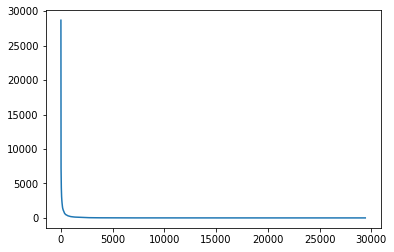

In [24]:
# sort = vec.idf_.argsort()
tf_tot = np.array(tf.sum(axis=0))[0]
sort = tf_tot.argsort()[::-1]

# np.array(vec.get_feature_names())[sort]
plt.plot(tf_tot[sort])
list(zip(np.array(vec.get_feature_names())[sort], tf_tot[sort]))


In [16]:
from numba import jit
import scipy.constants as cnst

# http://cse.iitkgp.ac.in/~pabitra/paper/stemmer.pdf
# @jit
# np.not_equal()

def str_D1(str1,str2, reg=None):
    if reg is None:
        reg = cnst.golden**(-np.arange(str1.shape[0]))
    ser = np.char.not_equal(str1,str2)*reg    
    return ser.sum()

def roll_D1(str1,str2, reg=None):
    if reg is None:
        reg = cnst.golden**(-np.arange(str1.shape[0]))
    ser = np.char.not_equal(str1,str2)*reg    
    
    left=np.roll(str1,1)
    ser_left = np.char.not_equal(left[1:], str2[:-1])*reg[1:]
    right = np.roll(str1,-1)
    ser_right = np.char.not_equal(left[:-1], str2[1:])*reg[1:]
    
    return ser.sum()*(ser_right.sum()+ser_left.sum())

In [17]:
first_zero = lambda l: next((i for i, x in enumerate(l) if x), None) # x!= 0 for strict match

def str_D2(str1,str2):
    lgth = max(len(str1[0]), len(str2[0]))
#     print(lgth)
    a = str1[0].ljust(lgth)
    b = str2[0].ljust(lgth)
    
    ser = [int(i!=j) for i,j in zip(a,b)]
    m = first_zero(ser)
    if (m is not None) and m>0:
        geo_sum = (1-0.5**(lgth-m+1))/(1-0.5)  # \sum_{i=m}^n 1/2^{i-m}
        return geo_sum/m 
    else:
        return 100.

def str_D3(str1,str2):
    lgth = max(len(str1), len(str2))
#     print(lgth)
    a = str1[0].ljust(lgth)
    b = str2[0].ljust(lgth)
    
    ser = [int(i!=j) for i,j in zip(a,b)]
    m = first_zero(ser)
    if (m is not None) and m>0:
        geo_sum = (1-0.5**(lgth-m+1))/(1-0.5)  # \sum_{i=m}^n 1/2^{i-m}
        return (lgth-m)*geo_sum/m 
    else:
        return 100.
    
def str_D4(str1,str2):
    lgth = max(len(str1), len(str2))
#     print(lgth)
    a = str1[0].ljust(lgth)
    b = str2[0].ljust(lgth)
    
    ser = [int(i!=j) for i,j in zip(a,b)]
    m = first_zero(ser)
    geo_sum = (1-0.5**(lgth-m+1))/(1-0.5)  # \sum_{i=m}^n 1/2^{i-m}
    return (lgth-m)*geo_sum/lgth 
    
pd.to_    

In [21]:
strs = np.array(vec.get_feature_names())[sort]
# chars = np.zeros((len(strs), max(len(i) for i in strs)), dtype='unicode_')
# for n,i in enumerate(strs):
#     chars[n, :len(i)] = list(i)
# chars.shape

In [23]:
# http://scikit-learn.org/stable/faq.html#how-do-i-deal-with-string-data-or-trees-graphs
from fuzzywuzzy import process, fuzz
process.extractBests('replace', strs, limit=20, score_cutoff=75)
# process.extract()
# fuzz.WRatio()

# X = np.arange(chars.shape[0]).reshape(-1, 1)  # index look-up
# def str_dist(x,y, reg=None):
#     i,j = int(x[0]), int(y[0])  # extract indices
#     return str_D1(chars[i], chars[j], reg=reg)

[('replace', 100),
 ('replaced', 93),
 ('replacer', 93),
 ('replacel', 93),
 ('rreplace', 93),
 ('replaces', 93),
 ('repalace', 93),
 ('repplace', 93),
 ('rerplace', 93),
 ('reaplace', 93),
 ('1replace', 93),
 ('treplace', 93),
 ('replkace', 93),
 ('reeplace', 93),
 ('replacet', 93),
 ('replaace', 93),
 ('replace5', 93),
 ('replace4', 93),
 ('replacew', 93),
 ('replace3', 93)]

In [163]:
from sklearn.cluster import DBSCAN
clust = DBSCAN(metric=str_dist, eps=.25, n_jobs=-1).fit(X)

grps = pd.DataFrame(index=strs,data=dict(cls=clust.labels_, score=tf_tot[sort][:2000]))
g = grps[grps.cls!=-1].groupby('cls')

grps['score_best'] = grps['score']
grps.loc[grps.cls!=-1,'score_best'] = g['score'].transform(max)
grps.sort_values(['score_best', 'score'], ascending=False).to_csv('clust_vocab_mine.csv', sep='\t')

## Deprecated

In [146]:
from scipy.spatial import distance

# reg=cnst.golden**(-np.arange(X.shape[1]))
# %lprun -f str_D1 distance.pdist(X[:100], str_D1)
distance.squareform(distance.pdist(X[:100], str_D1))

array([[ 0.        ,  0.52786405,  1.76393202, ...,  2.52786405,
         2.52786405,  2.52786405],
       [ 0.52786405,  0.        ,  1.76393202, ...,  2.47213595,
         2.52786405,  2.47213595],
       [ 1.76393202,  1.76393202,  0.        , ...,  2.52786405,
         2.52786405,  2.52786405],
       ..., 
       [ 2.52786405,  2.47213595,  2.52786405, ...,  0.        ,
         2.52786405,  2.47213595],
       [ 2.52786405,  2.52786405,  2.52786405, ...,  2.52786405,
         0.        ,  2.29179607],
       [ 2.52786405,  2.47213595,  2.52786405, ...,  2.47213595,
         2.29179607,  0.        ]])

In [147]:


# sns.clustermap(distance.squareform(distance.pdist(np.array(strs).reshape(-1,1), str_D1)),
#                yticklabels=strs, figsize=(15,20))
dist_mat = pd.DataFrame(data=distance.squareform(distance.pdist(X, str_D1)), 
             index=strs, columns = strs)

/home/tbsexton/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


accumulator     0.000000
accumulators    0.005025
accrepair       0.604878
access          0.604878
acc             0.604878
accessory       0.604878
accident        0.604878
actuator        0.750776
ac              0.986844
acond           0.986844
Name: accumulator, dtype: float64

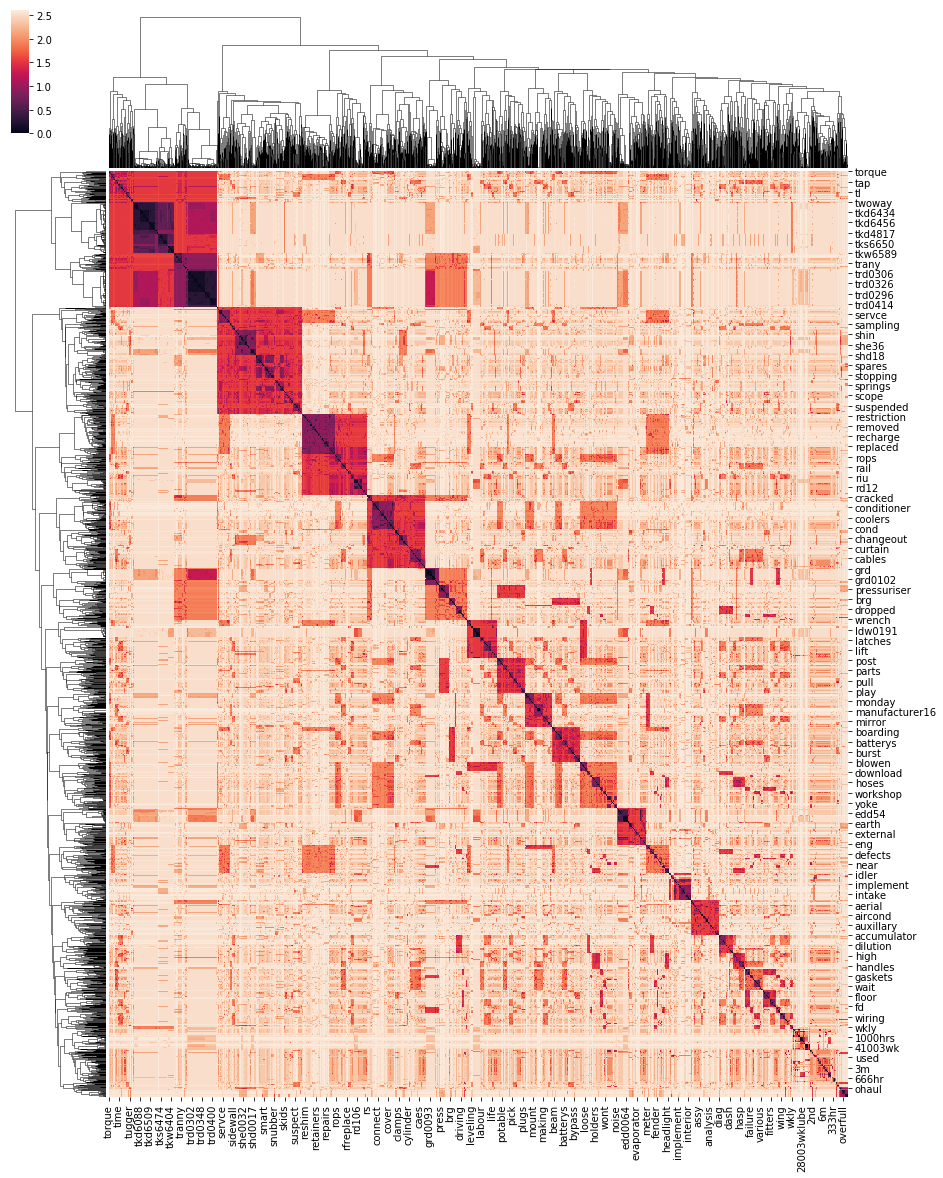

In [148]:
sns.clustermap(dist_mat,
               figsize=(15,20))

dist_mat['accumulator'].sort_values()[:10]

In [150]:
import pprint
from sklearn.cluster import DBSCAN
clust = DBSCAN(metric='precomputed', eps=.25).fit(dist_mat)

grps = pd.DataFrame(index=dist_mat.index,data=dict(cls=clust.labels_, score=tf_tot[sort][:2000]))
g = grps[grps.cls!=-1].groupby('cls')

grps['score_best'] = grps['score']
grps.loc[grps.cls!=-1,'score_best'] = g['score'].transform(max)
grps.sort_values(['score_best', 'score'], ascending=False).to_csv('clust_vocab_mine.csv', sep='\t')

In [218]:
from nltk.metrics.distance import edit_distance
# metrics.distance.edit_distance('abcde','abcfg')
ed_func = lambda x,y: edit_distance(x[0], y[0])
dist_mat = pd.DataFrame(data=distance.squareform(distance.pdist(np.array(strs).reshape(-1,1), 
                                                                ed_func)), 
             index=strs, columns = strs)
dist_mat['accumulator'].sort_values()[:10]

accumulator    0.0
contactor      7.0
motor          7.0
completed      7.0
operator       7.0
conveyor       8.0
clamp          8.0
coolant        8.0
filter         8.0
rebuilt        8.0
Name: accumulator, dtype: float64

In [230]:
vec_mat = vec.transform(series_itervals(raw_text)).toarray().T
dist_mat = pd.DataFrame(data=distance.squareform(distance.pdist(vec_mat,'cosine')), 
             index=strs, columns = strs)
dist_mat['accumulator'].sort_values()[:10]

accumulator    0.000000
check          0.322233
30bar          0.376422
charged        0.413130
requested      0.529558
charge         0.685735
lp             0.701154
25bar          0.723847
tag            0.729880
ok             0.746831
Name: accumulator, dtype: float64

In [11]:
for fname in data_dir.glob('TEMP_init-*.txt'):
    print(fname)

E:\Thurston\Documents\Code\Pycharm\ml-py\data\gs_data\TEMP_init-0.txt


In [129]:
# docs = textacy.fileio.read.read_csv(str(data_dir/'TEMP_init-0.txt'))
# Descriptions in RawText col
# content_stream, metadata_stream = textacy.fileio.split_record_fields(docs, 1)  

corpus = textacy.Corpus(u'en')

for fname in data_dir.glob('TEMP_init-*.txt'):
    print(fname)
    docs = textacy.fileio.read.read_csv(str(fname), delimiter='\t')
    content_stream, _ = textacy.fileio.split_record_fields(docs, 0)  
    corpus.add_texts(content_stream)

/home/tbsexton/Documents/Projects/DiagnosticKB/MaintenanceLanguageProcessing/data/gs_data/TEMP_init-0.txt


In [144]:
vsm = textacy.vsm.Vectorizer(weighting='tfidf',
                             normalize=False,
                             smooth_idf=False,
                             sublinear_tf=True,
                             min_df=2, max_df=0.95)  # each token in >2 docs, <95% of docs

terms_list = (doc.to_terms_list(ngrams=(1, 2, 3),
                                normalize=u'lemma',
                                named_entities=False,
                                filter_stops=True,  # Nope! Not needed :)
                                filter_punct=True,
                                as_strings=True) for doc in corpus)
doc_term_mat = vsm.fit_transform(terms_list)
doc_term_mat

def get_norm_tokens(doc_n, doc_term_mat, id_to_term):
    doc = doc_term_mat[doc_n].toarray()
    # we only care about unique tags, right?
    return set([id_to_term[i] for i in doc.nonzero()[1]])

# list(list(terms_list)[1])

In [145]:
get_norm_tokens(0, doc_term_mat, vsm.id_to_term)

{'bar',
 'bar feeder',
 'bar feeder chain',
 'break',
 'break bar',
 'break bar feeder',
 'chain',
 'feeder',
 'feeder chain',
 'repair'}

In [ ]:
vsm.sublinear_tf()